# Classification of Land Cover Using Cartographic Data

Where the data came from, what they did with originally, how well they did, etc., What the cover integers stand for.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [2]:
# Using the documentation, let's name our columns appropriately. We have 10 quantitative, numeric features,
# followed by 4 qualitative binary features for wilderness area, 40 qualitative binary features for soil type,
# and finally our outcome variable, 'Cover', which is an integer 1-7.

soil_types = ['Soil_Type_%.2d' %x for x in range(1, 41)]

col_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
             'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
             'Horizontal_Distance_To_Fire_Points', 'Wild_Area_1', 'Wild_Area_2', 'Wild_Area_3', 'Wild_Area_4']

col_names = col_names + soil_types + ['Cover']

In [3]:
raw_data = pd.read_csv('covtype.data', names=col_names)
raw_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Exploring the Data

Let's take a look at what we've got here. We already know what the columns mean from the documentation. The numeric features are self-explanitory with their column names. The 4 'Wild_Area' columns correspond to the following:

1. Rawah Wilderness Area
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

Similarly, the 40 'Soil_Type' features correspond to 40 specific soil types.

Each record should correspond to a single 'Wild_Area' and a single 'Soil_Type'. Let's dig a little bit deeper with the numeric features in particular.

In [4]:
# Do we have any missing data? 
raw_data.isnull().sum().sum()

0

The data is nice and clean! Many thanks to the creators of this data set.

### Distributions

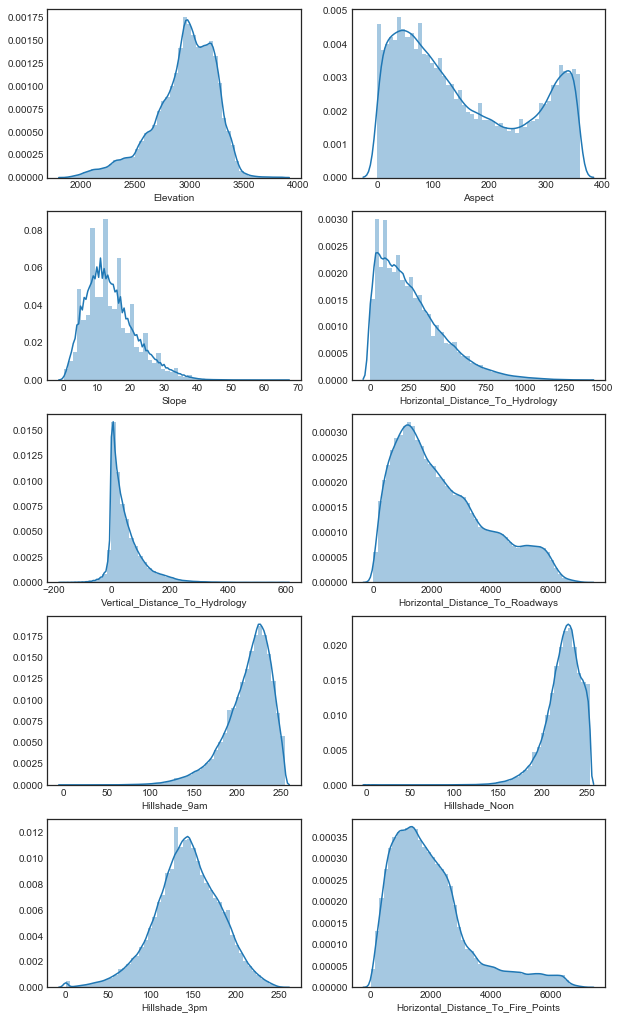

In [5]:
# Let's look at the distributions of our numeric variables.

g = plt.figure(figsize=(10,18))
i = 1
for col in raw_data.columns[:10]:
    plt.subplot(5, 2, i)
    sns.distplot(raw_data[col])
    i+=1

A few interesting things here: It appears that Slope, and to a lesser extent, Aspect are clumped around common values. Most likely they rounded Slope to the nearest 5 degrees (and Aspect to the nearest 45 degrees) during measurement. Other than that, this data is quite clean. There aren't any outliers to speak of, and the features are all fairly smooth. Aspect has an interesting quality, which is that it actually wraps around -- 360 degrees is the same as 0 degrees. We could potentially deal with this by transforming the data by taking the cosine.

In [6]:
print(raw_data.loc[:, 'Wild_Area_1':'Wild_Area_4'].sum())
print(raw_data.loc[:, 'Soil_Type_01':'Soil_Type_40'].sum())

Wild_Area_1    260796
Wild_Area_2     29884
Wild_Area_3    253364
Wild_Area_4     36968
dtype: int64
Soil_Type_01      3031
Soil_Type_02      7525
Soil_Type_03      4823
Soil_Type_04     12396
Soil_Type_05      1597
Soil_Type_06      6575
Soil_Type_07       105
Soil_Type_08       179
Soil_Type_09      1147
Soil_Type_10     32634
Soil_Type_11     12410
Soil_Type_12     29971
Soil_Type_13     17431
Soil_Type_14       599
Soil_Type_15         3
Soil_Type_16      2845
Soil_Type_17      3422
Soil_Type_18      1899
Soil_Type_19      4021
Soil_Type_20      9259
Soil_Type_21       838
Soil_Type_22     33373
Soil_Type_23     57752
Soil_Type_24     21278
Soil_Type_25       474
Soil_Type_26      2589
Soil_Type_27      1086
Soil_Type_28       946
Soil_Type_29    115247
Soil_Type_30     30170
Soil_Type_31     25666
Soil_Type_32     52519
Soil_Type_33     45154
Soil_Type_34      1611
Soil_Type_35      1891
Soil_Type_36       119
Soil_Type_37       298
Soil_Type_38     15573
Soil_Type_39     13806
So

Most of our data come from the second and fourth Wilderness Area. There are several rare soil types (< 500 examples), and a few with more than 50,000 examples. The rarity of certain soil samples means that we will miss some entirely in either our training set, in cross validation, or in our test set. 

And finally, let's look at our outcome variable, 'Cover'.

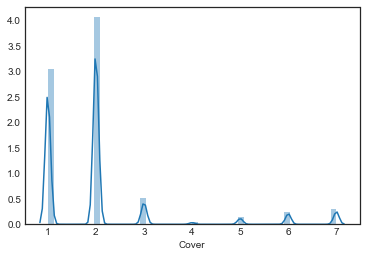

1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: Cover, dtype: int64


In [7]:
sns.distplot(raw_data.Cover)
plt.show()
print(raw_data.Cover.value_counts().sort_index())

We're dealing with a class imbalance here, so we'll likely want to resample the rare classes when we train our model. This also means that accuracy alone will be insufficient for judging the quality of our model. We'll have to be sure to get some of each cover type in our test set!

### Correlations

Finally, let's look at the correlations between some of the numeric data.

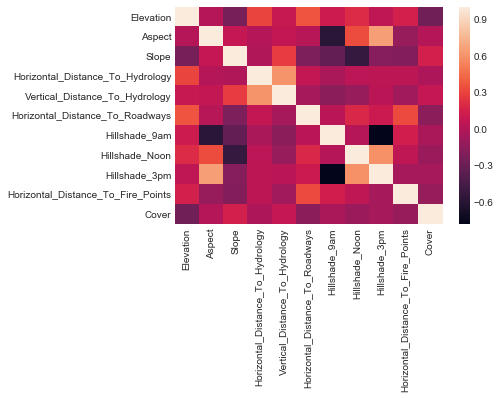

In [8]:
corr_cols = raw_data.columns[:10].tolist() + ['Cover']
corr_mat = raw_data.loc[:, corr_cols].corr()
sns.heatmap(corr_mat)
plt.show()

This looks good -- there are a few places with high correlation (Verticle and Horizontal distance to water, Aspect/Slope and Hillshade), but for the most part these variables are all fairly independent. That should allow us to extract the most possible information.

## Preparing the Data for Processing

### To do:
Let's go ahead and create a feature for the cosine of the Aspect. Our Soil_Type and Wild_Area are already essentially one-hot encoded, so nothing to do there. We'll need to separate our train/test data and resample the rare classes in the training data.

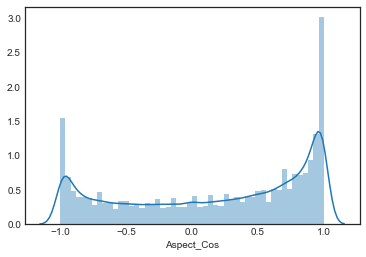

In [9]:
raw_data['Aspect_Cos'] = np.cos(np.radians(raw_data.Aspect))
sns.distplot(raw_data.Aspect_Cos)
plt.show()

Taking the cosine ends up clumping the data at the extremes -- this isn't ideal, but let's leave it in with unaltered Aspect and see how it goes.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

### Split the Data

In [11]:
data_train, data_test = train_test_split(raw_data, test_size=0.3)

Let's see if we've gotten all our classes in the test set.

In [12]:
data_test.Cover.value_counts().sort_index()

1    63634
2    84780
3    10735
4      844
5     2854
6     5266
7     6191
Name: Cover, dtype: int64

Great -- it looks like we do have enough of each so that random sample will pretty much always grab some of each. 

### Resampling

On to resampling the training set. Let's resample all but the most frequent class to have the same number for examples as the most frequent class (Cover = 2).

In [13]:
data_train.Cover.value_counts().sort_index()

1    148206
2    198521
3     25019
4      1903
5      6639
6     12101
7     14319
Name: Cover, dtype: int64

In [14]:
# First, separate out the different classes.

data_train_1 = data_train[data_train.Cover==1]
data_train_2 = data_train[data_train.Cover==2]
data_train_3 = data_train[data_train.Cover==3]
data_train_4 = data_train[data_train.Cover==4]
data_train_5 = data_train[data_train.Cover==5]
data_train_6 = data_train[data_train.Cover==6]
data_train_7 = data_train[data_train.Cover==7]

# Now, resample all to the length of data_train_2.

data_train_1 = resample(data_train_1, n_samples=len(data_train_2))
data_train_3 = resample(data_train_3, n_samples=len(data_train_2))
data_train_4 = resample(data_train_4, n_samples=len(data_train_2))
data_train_5 = resample(data_train_5, n_samples=len(data_train_2))
data_train_6 = resample(data_train_6, n_samples=len(data_train_2))
data_train_7 = resample(data_train_7, n_samples=len(data_train_2))

# And recombine.

data_train = pd.concat([data_train_1, data_train_2, data_train_3, data_train_4, data_train_5, 
                        data_train_6, data_train_7]).sample(frac=1)

print(data_train.Cover.value_counts().sort_index(), '\n\nTotal Length:', len(data_train))

1    198521
2    198521
3    198521
4    198521
5    198521
6    198521
7    198521
Name: Cover, dtype: int64 

Total Length: 1389647


In [15]:
# And finally, we'll create our X and Y arrays for processing.

X_train = data_train.loc[:, ~data_train.columns.isin(['Cover'])]
Y_train = data_train.Cover
X_test = data_test.loc[:, ~data_train.columns.isin(['Cover'])]
Y_test = data_test.Cover

print('Sanity check on array shapes:\n', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Sanity check on array shapes:
 (1389647, 55) (1389647,) (174304, 55) (174304,)


## Feature Selection

Let's take a look at how our features behave, and see how using selected features compares to using the whole feature set. We'll try out RFE, Select K Best, feature importances from random forest, and PCA. Let's start with feature importances to get a sense of how many features we'll want to keep.

In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, average_precision_score

In [17]:
# We'll run an unmodified random forest to get feature importances. 
# This will also be a good way to see where we're starting from with regards to model accuracy.

rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train)
Y_pred = rfc.predict(X_test)
print(rfc.score(X_test, Y_test))
print(confusion_matrix(Y_test, Y_pred))

0.937150036717
[[59063  4278    11     0    36    16   230]
 [ 3387 80671   284     2   180   210    46]
 [    1   171 10296    41    13   213     0]
 [    0     0   135   683     0    26     0]
 [   34   494    37     0  2278    11     0]
 [    8   187   535    34     4  4498     0]
 [  288    42     0     0     1     0  5860]]


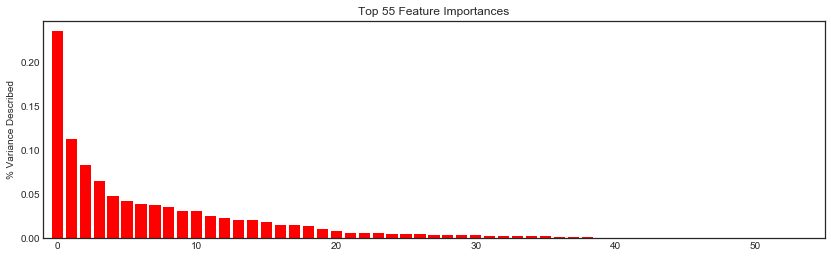

In [18]:
# Extract the top X feature importances. With only 55 features, we'll just look at all of them.

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:55]

# Plot the feature importances

plt.figure(figsize=(14, 4))
plt.title("Top {} Feature Importances".format(len(top_indices)))
plt.bar(range(len(top_indices)), importances[top_indices],
       color="r", align="center")
plt.xlim([-1, len(top_indices)])
plt.ylabel('% of Trees Accounted For')
plt.show()

In [21]:
# And let's see the total variance explain with the top X features.

for n_idx in range(5, 56, 5):
    print('Percentage of trees accounted for with {} features: {}'.format(n_idx, importances[indices[:n_idx]].sum()))
print('Total Features: ' + str(len(indices)))

Percentage of trees accounted for with 5 features: 0.5434278697850932
Percentage of trees accounted for with 10 features: 0.7294442595766693
Percentage of trees accounted for with 15 features: 0.8509604810333283
Percentage of trees accounted for with 20 features: 0.9238018584683944
Percentage of trees accounted for with 25 features: 0.9543723055047937
Percentage of trees accounted for with 30 features: 0.9760154372838504
Percentage of trees accounted for with 35 features: 0.9896467582383845
Percentage of trees accounted for with 40 features: 0.996381155194
Percentage of trees accounted for with 45 features: 0.9989340096109895
Percentage of trees accounted for with 50 features: 0.9998494595223278
Percentage of trees accounted for with 55 features: 1.0000000000000002
Total Features: 55


I suspect we're going to end up using this whole feature set, but let's see how those techniques do. Let's reduce to 25 features since we could potentially account for 95% of the variance. What are these features?

In [20]:
n_indices = 25
X_train.columns[indices[:n_indices]]

Index(['Elevation', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Wild_Area_4', 'Aspect_Cos', 'Hillshade_9am', 'Hillshade_3pm', 'Aspect',
       'Hillshade_Noon', 'Slope', 'Soil_Type_39', 'Soil_Type_03',
       'Soil_Type_10', 'Soil_Type_38', 'Wild_Area_3', 'Soil_Type_04',
       'Wild_Area_1', 'Soil_Type_30', 'Soil_Type_02', 'Soil_Type_40',
       'Soil_Type_13', 'Soil_Type_17', 'Soil_Type_23'],
      dtype='object')

In [22]:
# And now choosing those best features to be in our modified feature set:

X_train_rfc = X_train.loc[:, X_train.columns[indices[:n_indices]]]
X_test_rfc = X_test.loc[:, X_train.columns[indices[:n_indices]]]
print(X_train_rfc.shape, X_test_rfc.shape)

(1389647, 25) (174304, 25)


In [25]:
# Selection with RFE: We'll use KNN as the estimator because it's quick.
# This might mean our result is worse than if we used random forest.

rfe = RFE(estimator=KNeighborsClassifier(n_neighbors=4), n_features_to_select=n_indices)
rfe.fit(X_train, Y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [23]:
# Selection with Select K Best:

skb = SelectKBest(k=n_indices)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

In [24]:
# Decomposition with PCA:

pca = PCA(n_components=n_indices)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Now let's see how they all compare! Again, we'll test them out with an unmodified random forest.

In [28]:
# Simply taking the cross validation score of each training set, using random forest.

print('Scores with all features: ')
print(cross_val_score(rfc, X_train, Y_train, cv=4))

print('Scores with feature importances: ')
print(cross_val_score(rfc, X_train_rfc, Y_train, cv=4))

print('Scores with RFE: ')
print(cross_val_score(rfc, X_train_rfe, Y_train, cv=4))

print('Scores with Select K Best: ')
print(cross_val_score(rfc, X_train_skb, Y_train, cv=4))

print('Scores with PCA: ')
print(cross_val_score(rfc, X_train_pca, Y_train, cv=4))

Scores with all features: 
[ 0.98652052  0.9871276   0.98791054  0.9874212 ]
Scores with feature importances: 
[ 0.9877755   0.98669871  0.98727152  0.98789327]
Scores with RFE: 
[ 0.53908416  0.53937423  0.54023776  0.53885035]
Scores with Select K Best: 
[ 0.9881612   0.98815233  0.98837109  0.98853804]
Scores with PCA: 
[ 0.98827058  0.98817248  0.98836245  0.98818975]


It actually looks like we did better with Select K Best and PCA than we did with our full feature set! That may be because our random forest was limited in the number of estimators it could use, and wasn't able to fully take advantage of the extra features. Let's use Select K Best for the next section -- it has the advantage over PCA that we'll be able to see which columns are most important. 

## Model Selection

Let's run our data through several models, tune parameters for each, see how they compare, and choose the best one to move forward with. We'll take a look at logistic regression, K-nearest neighbors, naive Bayes, SVC, decision tree, random forest, and gradient boosting. We'll also keep track of how long each takes to run so we don't get stuck with a behemoth.

In [ ]:
# We'll use datetime to measure our processing speed, and use a couple functions to cut down on typing.

import datetime

def t_now(): return datetime.datetime.now()
def t_dif(tic): return str(t_now() - tic)

In [30]:
# Logistic Regression

tic = t_now()

lgr = LogisticRegression(penalty='l2')
print(cross_val_score(lgr, X_train_skb, Y_train, cv=4))

print(t_dif(tic))

[ 0.63906199  0.64111568  0.63858265  0.64168562]
0:50:03.812087


Well, that took quite a while and didn't do very well, especially since we know our random forest can do so much better. I wonder why this took so long? I think of logistic regression as being a relatively simple model, however it may be that it scales with the number of examples, and we've got over a million in our training set.

In [34]:
# K Nearest Neighbors

tic = t_now()

knc = KNeighborsClassifier(n_neighbors=4)
print(cross_val_score(knc, X_train_skb, Y_train, cv=4))

print(t_dif(tic))

[ 0.98567715  0.98602228  0.98559627  0.98565384]
0:01:27.245324


Wow, KNN did great and worked very quickly. This one is worth pursuing a bit further.

In [ ]:
# Naive Bayes. Let's use PCA here so we're more confident about our features being independent.

tic = t_now()

bnb = BernoulliNB()
print(cross_val_score(bnb, X_train_pca, Y_train, cv=4))

print(t_dif(tic))

[ 0.52735474  0.52758988  0.52680406  0.52681846]
0:00:09.779712


Yikes -- Naive Bayes did poorly, but at least it did it quickly. 

In [ ]:
# SVC

tic = t_now()

svc = SVC()
print(cross_val_score(svc, X_train_skb, Y_train, cv=4))

print(t_dif(tic))

Well, that took way too long. 

In [ ]:
tic = t_now()

dtc_params = {max_depth:[8, 32, None],
              min_samples_split:[2, 8, 32],
              max_features:['sqrt', None]}
dtc_grid = GridsearchCV(DecisionTreeClassifier(), dtc_params, cv=4, n_jobs=-1)
dtc_grid.fit(X_train_skb, Y_train)
print('Best Score: ', dtc_grid.best_score_)
print('Best Parameters: ', dtc_grid.best_params_)

print(t_dif(tic))

how'd it do?

In [ ]:
tic = t_now()

rfc_params = {n_estimators:[8, 24, 64],
              min_samples_split:[2, 8],
              max_features:['sqrt', None]}
rfc_grid = GridsearchCV(RandomForestClassifier(), rfc_params, cv=4, n_jobs=-1)
rfc_grid.fit(X_train_skb, Y_train)
print('Best Score: ', rfc_grid.best_score_)
print('Best Parameters: ', rfc_grid.best_params_)

print(t_dif(tic))

In [ ]:
tic = t_now()

gbc_params = {n_estimators:[100, 200],
              learning_rate:[0.1, 0.3],
              max_depth:[3, 6]}
gbc_grid = GridsearchCV(GradientBoostingClassifier(), gbc_params, cv=4, n_jobs=-1)
gbc_grid.fit(X_train_skb, Y_train)
print('Best Score: ', gbc_grid.best_score_)
print('Best Parameters: ', gbc_grid.best_params_)

print(t_dif(tic))